In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import random

import warnings
import cmdstanpy
from cmdstanpy import CmdStanModel

import arviz as az
import scipy.stats as stats
# warnings.filterwarnings('ignore')

##### Reading data from a concatenated file

In [21]:
# Read from excel file
df_ac  = pd.read_excel("data.xlsx", sheet_name="Raw_data")

# Select only essential columns
df = df_ac[['Year', 'Married', 'Income per member', "Mean age", "Household", "Total"]]

##### Data splitting

In [22]:
# All data for testing purposes
df_all = df

# Selection of years - 5 years are left for checking results
df = df[:25]

# Quick look at the table
df.head()

,Year,Married,Income per member,Mean age,Household,Total
0,1993,114601,15500,25.50,96391,197254
1,1994,115253,16300,25.60,97107,200800
2,1995,116554,16940,25.70,98990,202732
3,1996,116561,17850,25.95,99627,204624
4,1997,116752,18940,25.90,101018,207235


##### Preliminary data analysis

In [23]:
# Data for models
df.describe()

,Year,Married,Income per member,Mean age,Household,Total
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,2005.000000,125517.720000,24412.000000,26.690000,112143.720000,229046.720000
std,7.359801,6685.028917,5173.445821,0.941962,9520.963469,19449.196392
min,1993.000000,114601.000000,15500.000000,25.500000,96391.000000,197254.000000
25%,1999.000000,119040.000000,21060.000000,25.950000,103874.000000,211676.000000
50%,2005.000000,127142.000000,24670.000000,26.350000,113343.000000,230272.000000
75%,2011.000000,130767.000000,27330.000000,27.400000,119927.000000,245275.000000
max,2017.000000,135749.000000,34640.000000,28.450000,126224.000000,259063.000000


In [24]:
# Data for checking purposes
df_all[25:].describe()

,Year,Married,Income per member,Mean age,Household,Total
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,2020.000000,136807.400000,39212.000000,29.120000,129012.400000,265193.600000
std,1.581139,922.352319,2530.784463,0.270647,1358.823866,2669.521923
min,2018.000000,135704.000000,35700.000000,28.800000,127586.000000,262058.000000
25%,2019.000000,136297.000000,38410.000000,28.900000,128451.000000,263457.000000
50%,2020.000000,136506.000000,38760.000000,29.150000,128579.000000,264696.000000
75%,2021.000000,137758.000000,40860.000000,29.300000,129244.000000,267174.000000
max,2022.000000,137772.000000,42330.000000,29.450000,131202.000000,268583.000000


### 3. Model creation

We have created two models: 
- the first model predicts the number of individuals after marriage based on data about average household income per member, 
- the second model additionally utilizes the number of available housing units and the average age of entering first marriage.

We incorporated additional information with the hope that expanding the context would improve the results and make them more reflective of reality.

Model 1:

- Parameters:  $\alpha$, $\beta$, $\sigma$
- Data: Average household income per member
- Linear equation: f (income) = $\alpha$*income + $\beta$
- Sampling: y (income) = 

Model 2:

- Parameters: $\alpha_1$, $\alpha_2$, $\alpha_3$, $\beta$, $\sigma$
- Data: Average household income per member, number of available housing units, average age of first marriage
- równanie...




##### Differences
Despite highly correlated features, adding additional parameters makes sense as it complicates the equation but does not significantly impact the prediction. The impact is smaller, but the difference is noticeable.

In [25]:
# Creating models

N = 25
R = 100

model_1_prior = CmdStanModel(stan_file='prior.stan')
model_1_posterior = CmdStanModel(stan_file='posterior.stan')
model_2_prior = CmdStanModel(stan_file='tri_prior.stan')
model_2_posterior = CmdStanModel(stan_file='tri_posterior.stan')

14:02:17 - cmdstanpy - INFO - compiling stan file C:\Users\Julia\Desktop\Data analysis\Project\DA_project\posterior.stan to exe file C:\Users\Julia\Desktop\Data analysis\Project\DA_project\posterior.exe
14:02:37 - cmdstanpy - INFO - compiled model executable: C:\Users\Julia\Desktop\Data analysis\Project\DA_project\posterior.exe


### 4. Priors

- Is it explained why particular priors for parameters were selected [1 pt]
- Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
- Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
- How prior parameters were selected [1 pt]

##### Prior parameters selection
The prior parameters were chosen by fitting a function that closely resembled the trend of marriages over the years. In this case, it turned out to be a linear function (for the first model) or closely approximated a linear function within this range (for the second model).

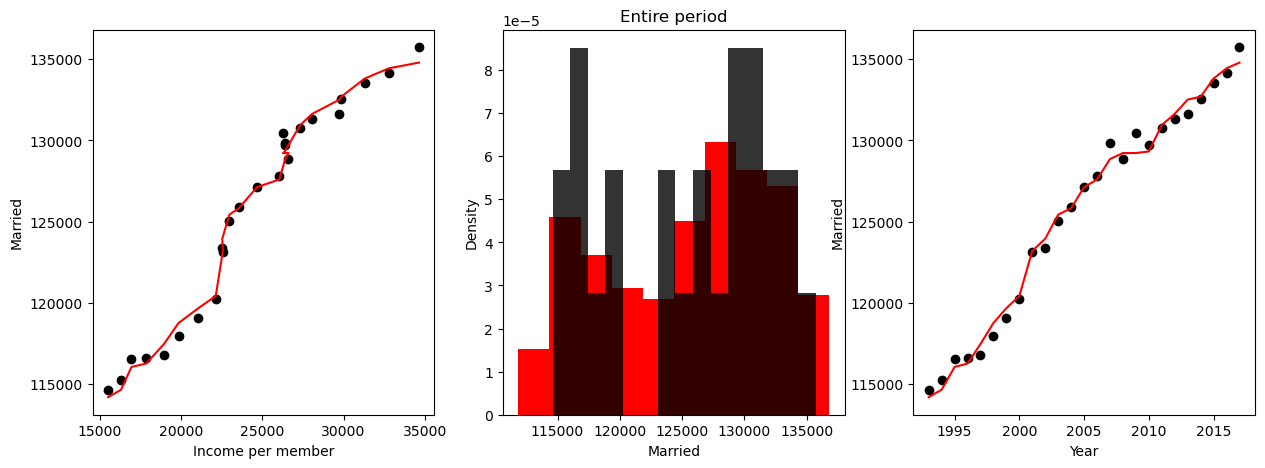

In [26]:
# Parameters testing for Model 2

# Sample data
x = df['Income per member']
y = df['Household']
z = df['Mean age']

c = df['Married']
sigma = 1000

X = np.column_stack((np.ones_like(x), x, y, z))  # Add a column of ones for the intercept
coefficients = np.linalg.lstsq(X, c, rcond=None)[0]

# Extract coefficients
intercept, slope_x, slope_y, slope_z = coefficients

# Define points for the plane
z_plane = slope_x * x + slope_y * y + slope_z * z + intercept 

intercept, slope_x, slope_y, slope_z


plt.figure(figsize=(15,5))


plt.subplot(1,3,1)
plt.scatter(df['Income per member'], df['Married'], color="black")
plt.plot(df['Income per member'], slope_x*df['Income per member'] + slope_y*df['Household'] + slope_z*df['Mean age'] + intercept, color="red")
plt.xlabel('Income per member')
plt.ylabel('Married')


plt.subplot(1,3,2)
sim = random.normal(slope_x*df['Income per member'] + slope_y*df['Household'] + slope_z*df['Mean age'] + intercept, sigma, (100,25))

for i in range(len(sim)):
    plt.hist(sim.flatten().tolist(), color='red', alpha = 0.3, density=True)

plt.hist(df['Married'], color='black',bins=15, alpha = 0.8, density=True)
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')


plt.subplot(1,3,3)
plt.scatter(df["Year"], df['Married'], color="black")
plt.plot(df["Year"], slope_x*df['Income per member'] + slope_y*df['Household'] + slope_z*df['Mean age'] + intercept, color="red")
plt.xlabel('Year')
plt.ylabel('Married')


plt.show()

#### 4.1. Model 1.

In [27]:
# Setting data
data = {'N': N, 'income': df['Income per member']}

# creating prior for Model 1
prior_1 = model_1_prior.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

14:02:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


14:02:40 - cmdstanpy - INFO - CmdStan done processing.


In [28]:
prior_1.draws_pd()

,lp__,accept_stat__,alpha,beta,sigma,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],...,y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23],y_sim[24],y_sim[25]
0,0.0,0.0,1.39541,95965.8,363.866,117641.0,118205.0,119694.0,121310.0,123219.0,...,133201.0,132597.0,132819.0,134335.0,135459.0,137393.0,137668.0,139021.0,141757.0,144066.0
1,0.0,0.0,1.31904,94585.6,920.009,115618.0,116481.0,114319.0,119083.0,120051.0,...,129924.0,127965.0,128886.0,130385.0,132314.0,134090.0,134564.0,134769.0,137831.0,140274.0
2,0.0,0.0,1.32074,95939.3,1369.850,118025.0,119129.0,119395.0,120566.0,118716.0,...,129258.0,131617.0,133192.0,131577.0,130381.0,135740.0,135535.0,135992.0,140704.0,141658.0
3,0.0,0.0,1.27851,93917.6,1448.920,114407.0,113572.0,115352.0,113999.0,116686.0,...,126430.0,127360.0,129535.0,128749.0,129187.0,130304.0,130324.0,135987.0,135567.0,137973.0
4,0.0,0.0,1.29026,95390.9,1441.340,112325.0,116740.0,113999.0,117546.0,118565.0,...,128488.0,129924.0,130377.0,131357.0,129797.0,135208.0,134845.0,134200.0,139138.0,140197.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,1.31033,94430.7,532.655,114351.0,115648.0,116806.0,118602.0,119131.0,...,128824.0,129325.0,128700.0,130701.0,131043.0,133783.0,133867.0,134757.0,136749.0,139112.0
96,0.0,0.0,1.22993,95747.7,809.024,115040.0,117460.0,115017.0,116284.0,119614.0,...,127486.0,128632.0,128578.0,128741.0,129549.0,132029.0,132914.0,133563.0,136398.0,138342.0
97,0.0,0.0,1.32200,94757.8,1203.580,115430.0,117106.0,117174.0,120095.0,117182.0,...,130557.0,130432.0,130465.0,130598.0,132245.0,134293.0,134099.0,135852.0,138473.0,139727.0
98,0.0,0.0,1.21926,93646.4,504.891,112591.0,114202.0,115266.0,116211.0,116792.0,...,126088.0,125178.0,126235.0,127169.0,127822.0,129899.0,129907.0,132067.0,133500.0,135687.0


#### 4.2. Model 2.

In [29]:
# Setting data
data = {'N': N, 'income': df['Income per member'], 'household': df['Household'], 'mean_age': df['Mean age']}

# creating prior for Model 1
prior_2 = model_2_prior.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

14:02:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


14:02:40 - cmdstanpy - INFO - CmdStan done processing.


In [30]:
prior_2.draws_pd()

,lp__,accept_stat__,alpha_1,alpha_2,alpha_3,beta,sigma,y_sim[1],y_sim[2],y_sim[3],...,y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23],y_sim[24],y_sim[25]
0,0.0,0.0,0.014708,0.817772,1254.55,68755.2,30.5289,115825.0,116326.0,117783.0,...,131093.0,131115.0,131229.0,132848.0,133564.0,134408.0,134655.0,135764.0,136473.0,136791.0
1,0.0,0.0,0.011840,0.816388,1288.60,62824.4,151.7530,108921.0,109444.0,110657.0,...,124126.0,124052.0,124206.0,125565.0,126442.0,127327.0,127691.0,128748.0,129381.0,129800.0
2,0.0,0.0,0.013213,0.817903,1295.36,65232.6,213.5020,111550.0,111545.0,113237.0,...,126475.0,126247.0,126774.0,128185.0,128966.0,129649.0,130144.0,131181.0,131546.0,132043.0
3,0.0,0.0,0.010109,0.800013,1304.34,66800.5,85.4239,110869.0,111489.0,112641.0,...,125590.0,125581.0,125738.0,127315.0,128029.0,128628.0,128989.0,129878.0,130628.0,130948.0
4,0.0,0.0,0.012259,0.794668,1259.70,70734.9,75.3730,115375.0,115772.0,117214.0,...,130157.0,130192.0,130350.0,131875.0,132475.0,133480.0,133521.0,134659.0,135296.0,135759.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.010789,0.799298,1277.12,66982.7,130.9510,111696.0,112137.0,113748.0,...,126652.0,126402.0,126390.0,128281.0,128886.0,129672.0,129624.0,130905.0,131740.0,131847.0
96,0.0,0.0,0.012588,0.813148,1287.05,69854.7,173.8200,115592.0,116273.0,117584.0,...,130752.0,131016.0,130790.0,132424.0,133237.0,133995.0,134051.0,135283.0,136125.0,136335.0
97,0.0,0.0,0.013253,0.812071,1244.70,68002.4,17.0457,114736.0,115226.0,116606.0,...,129870.0,129919.0,130029.0,131646.0,132327.0,133246.0,133442.0,134560.0,135188.0,135601.0
98,0.0,0.0,0.011151,0.806342,1310.00,63997.8,129.9900,108454.0,108792.0,110407.0,...,123358.0,123377.0,123584.0,125314.0,126066.0,126668.0,126864.0,128147.0,128654.0,128956.0


##### Prior predictive checks for parameters

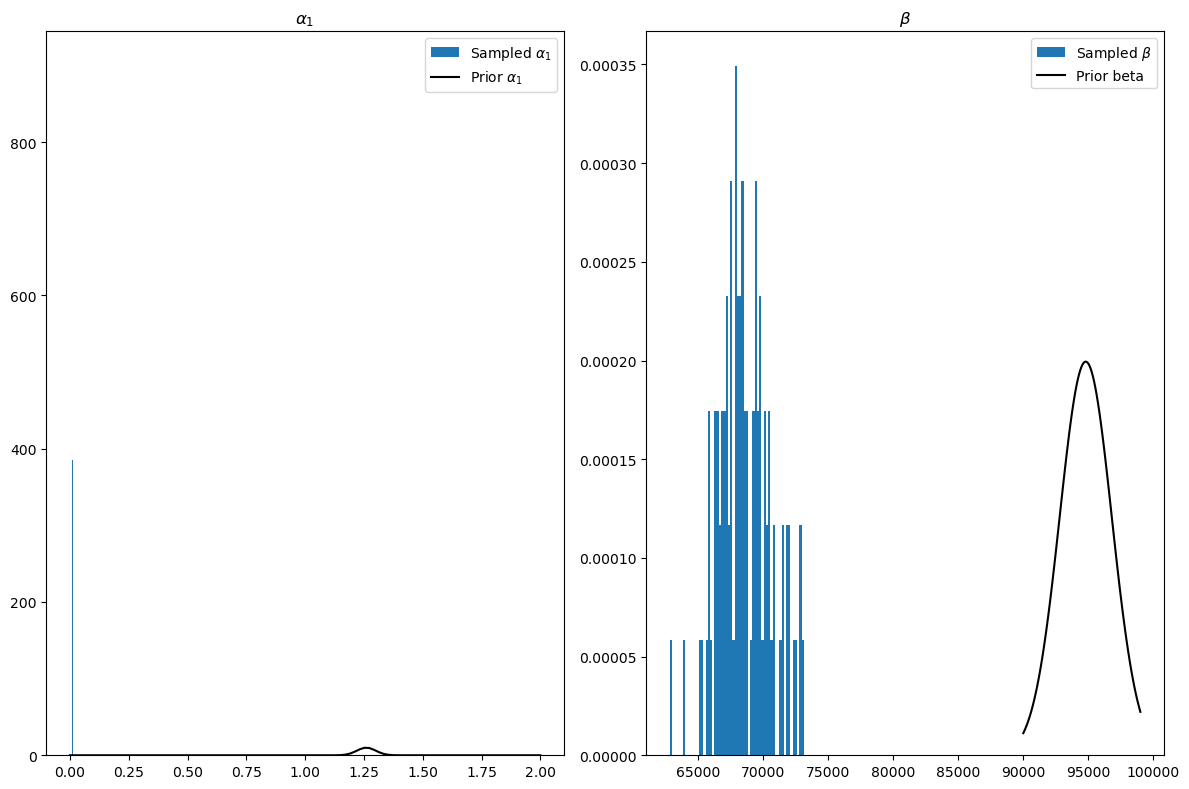

In [31]:
alpha1_pred = prior_2.stan_variable('alpha_1')
beta_pred= prior_2.stan_variable('beta')

fig,axes = plt.subplots(1,2,figsize = (12,8), tight_layout=True)
x = np.linspace(0,2,100)
y = stats.norm.pdf(x=x,loc=1.26, scale=0.04)
axes[0].hist(alpha1_pred, bins=60,label=r'Sampled $\alpha_1$',density=True)
axes[0].set_title(r'$\alpha_1$')
axes[0].plot(x,y,label=r'Prior $\alpha_1$',color='k')
axes[0].legend()

x = np.linspace(90000, 99000, 100)
y = stats.norm.pdf(x=x,loc=94800, scale=2000)
axes[1].hist(beta_pred, bins=60,label=r'Sampled $\beta$',density=True)
axes[1].set_title(r'$\beta$')
axes[1].plot(x,y,label = 'Prior beta',color='k')
axes[1].legend()

##### Prior predictive checks for measurements

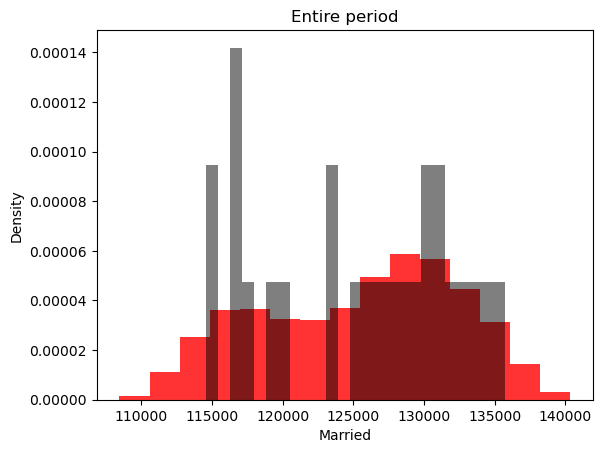

In [32]:
prior_2_combined = []
for i in range(R):
    prior_2_combined.extend(prior_2.y_sim[i])
plt.hist(prior_2_combined, bins=15, color='red', alpha = 0.8, density=True)
plt.hist(df['Married'], bins=25, color='black', alpha = 0.5, density=True)
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.show()

### 6. Posterior (model 2) - analysis

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

In [33]:
data = {'N': N, 'income': df['Income per member'], 'household': df['Household'], 'mean_age': df['Mean age'], 'y': df['Married']}
post_2 = model_2_posterior.sample(data=data, chains=1, iter_sampling=100)

14:02:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                       


14:02:42 - cmdstanpy - INFO - CmdStan done processing.


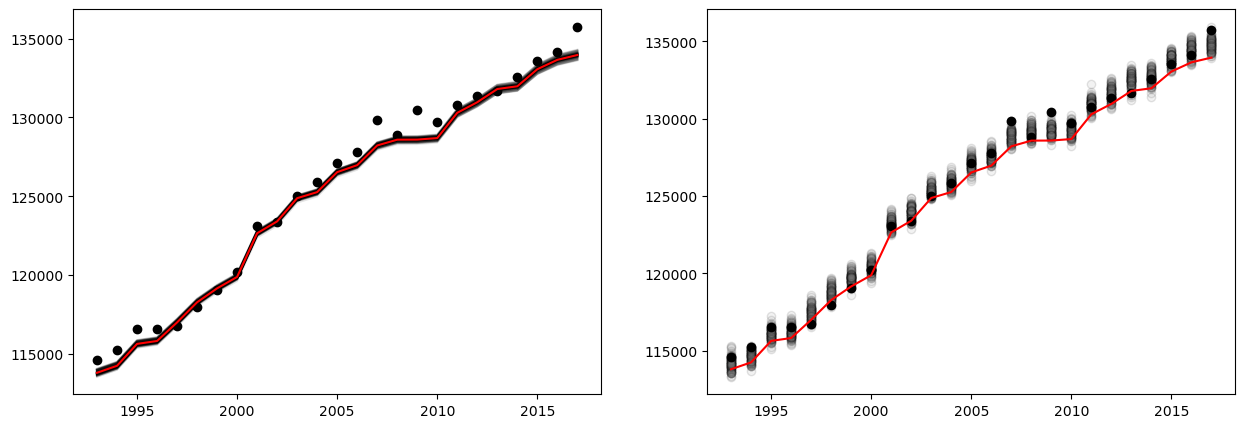

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i in range(len(post_2.y_sim)):
    plt.plot(df['Year'], -post_2.alpha_1[i]*df['Income per member'] + post_2.alpha_2[i]*df['Household'] - post_2.alpha_3[i]*df['Mean age'] + post_2.beta[i], color='black', alpha = 0.1)
plt.plot(df['Year'], -post_2.alpha_1.mean()*df['Income per member'] + post_2.alpha_2.mean()*df['Household'] - post_2.alpha_3.mean()*df['Mean age'] + post_2.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.subplot(1,2,2)
for i in range(len(post_2.y_sim)):
    plt.scatter(df['Year'], post_2.y_sim[i], color='gray', alpha = 0.1,edgecolors= "black")
plt.plot(df['Year'], -post_2.alpha_1.mean()*df['Income per member'] + post_2.alpha_2.mean()*df['Household'] - post_2.alpha_3.mean()*df['Mean age'] + post_2.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.show()

In [35]:
post_2.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-187.526000,0.243384,1.726270,-190.692000,-187.231000,-185.217000,50.3077,670.769,1.030640
alpha_1,0.012064,0.000158,0.000960,0.010617,0.012084,0.013468,36.9284,492.379,1.033800
alpha_2,0.810063,0.000601,0.006885,0.798312,0.810243,0.821569,131.3010,1750.680,0.992963
alpha_3,1282.940000,2.386540,19.666400,1252.260000,1283.460000,1313.210000,67.9065,905.420,1.034590
beta,68627.200000,66.216100,753.004000,67237.300000,68607.600000,69866.300000,129.3200,1724.270,0.999116
sigma,360.411000,2.726230,26.747000,320.083000,357.803000,409.174000,96.2558,1283.410,0.991477
y_sim[1],114175.000000,44.475200,398.196000,113562.000000,114153.000000,114734.000000,80.1603,1068.800,0.990585
y_sim[2],114690.000000,35.370400,359.154000,114038.000000,114712.000000,115215.000000,103.1060,1374.740,0.994591
y_sim[3],116069.000000,34.400000,350.430000,115520.000000,116083.000000,116590.000000,103.7730,1383.650,0.990671
y_sim[4],116235.000000,38.695200,381.119000,115648.000000,116207.000000,116872.000000,97.0079,1293.440,0.994884


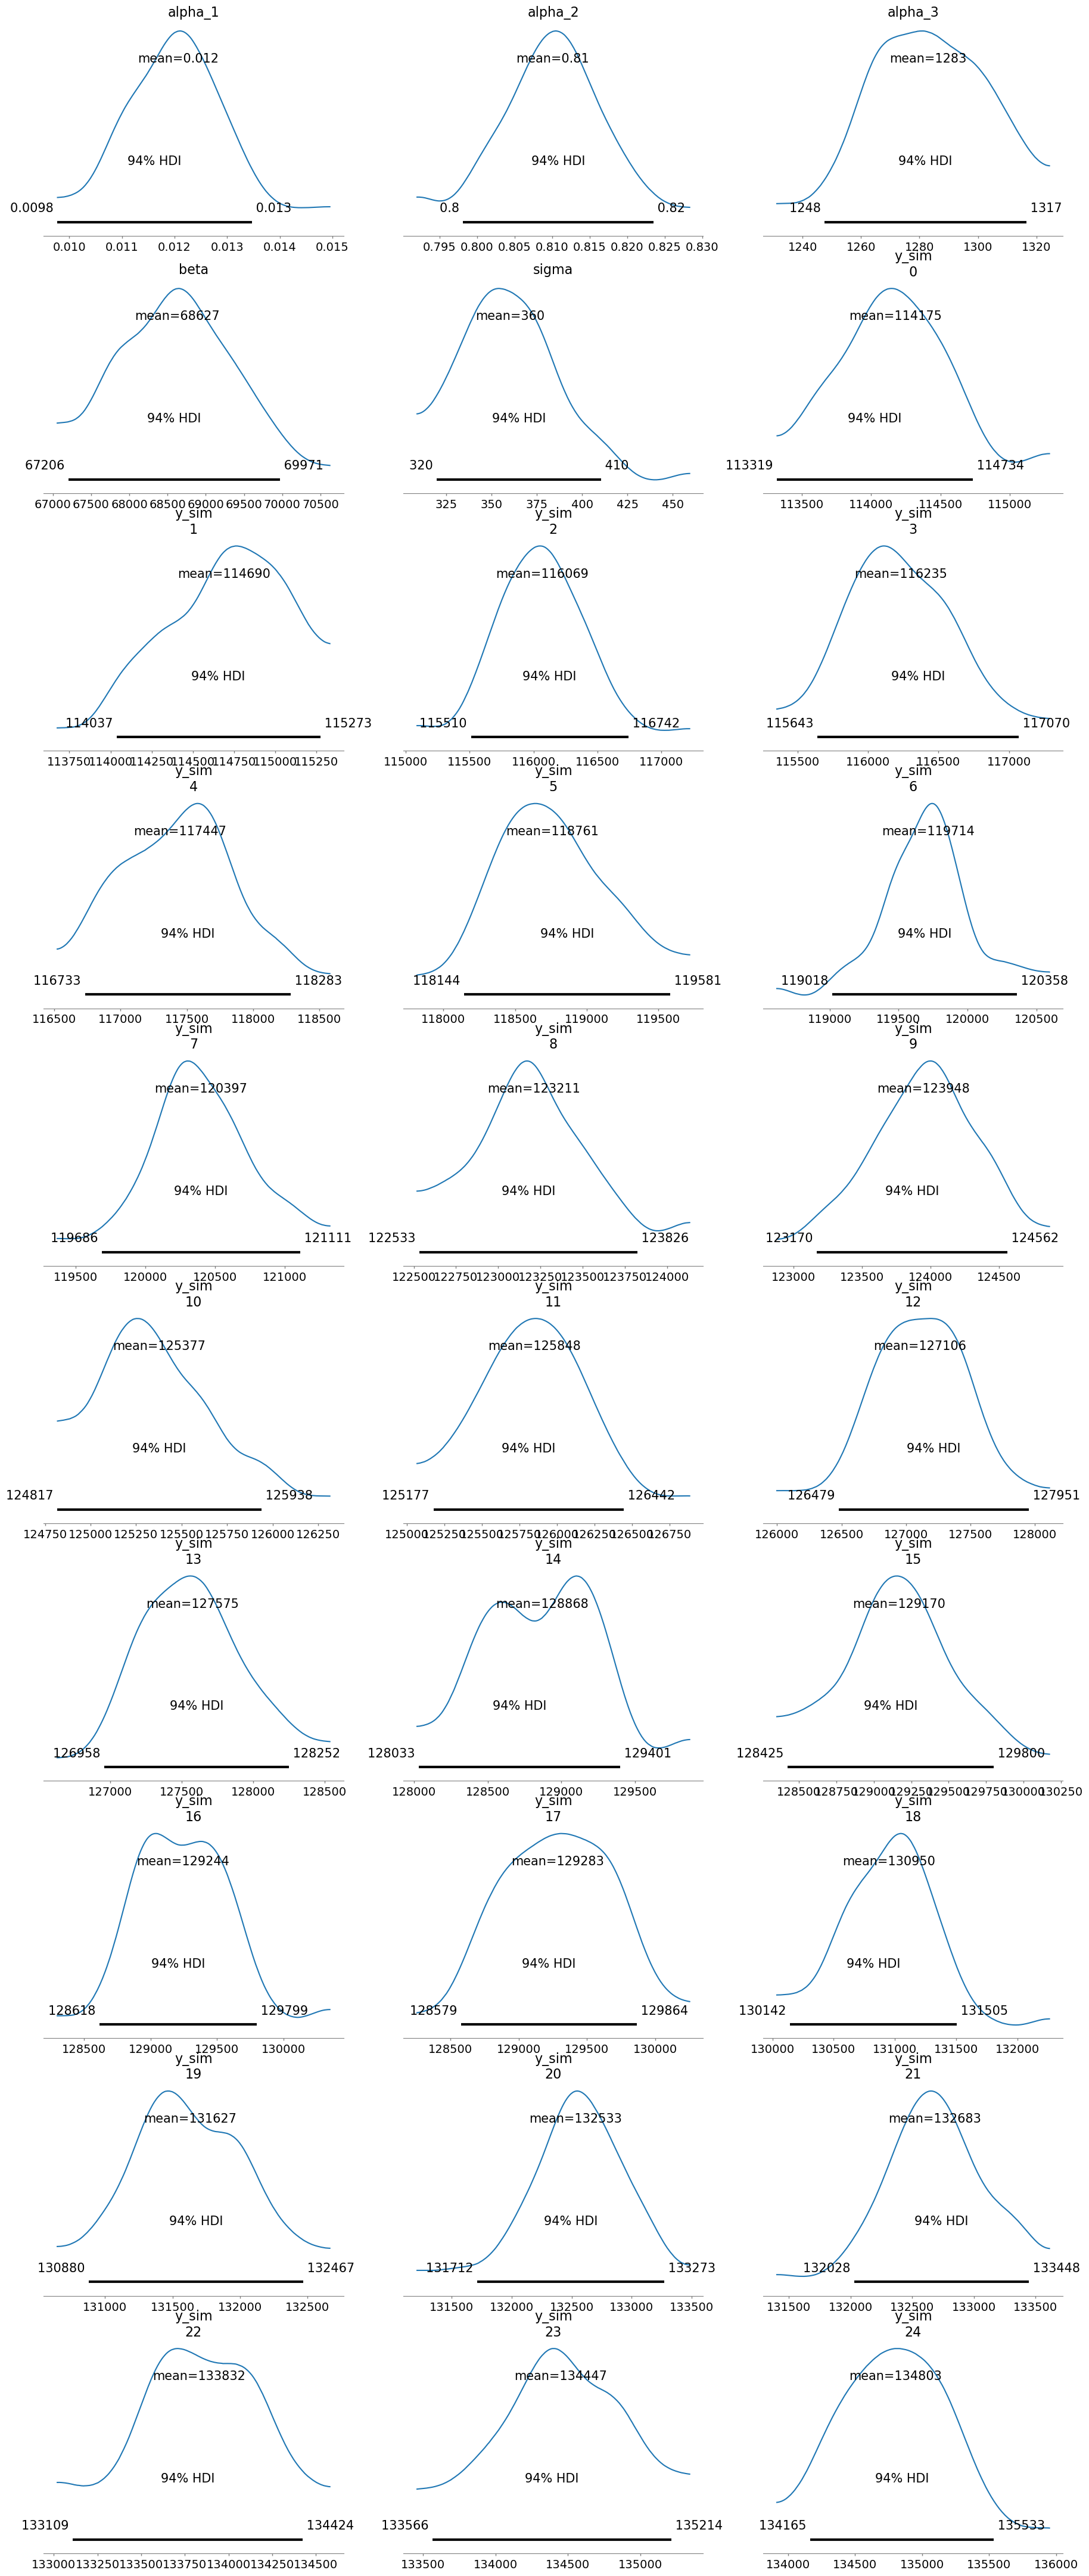

In [36]:
az.plot_posterior(post_2)
plt.show()

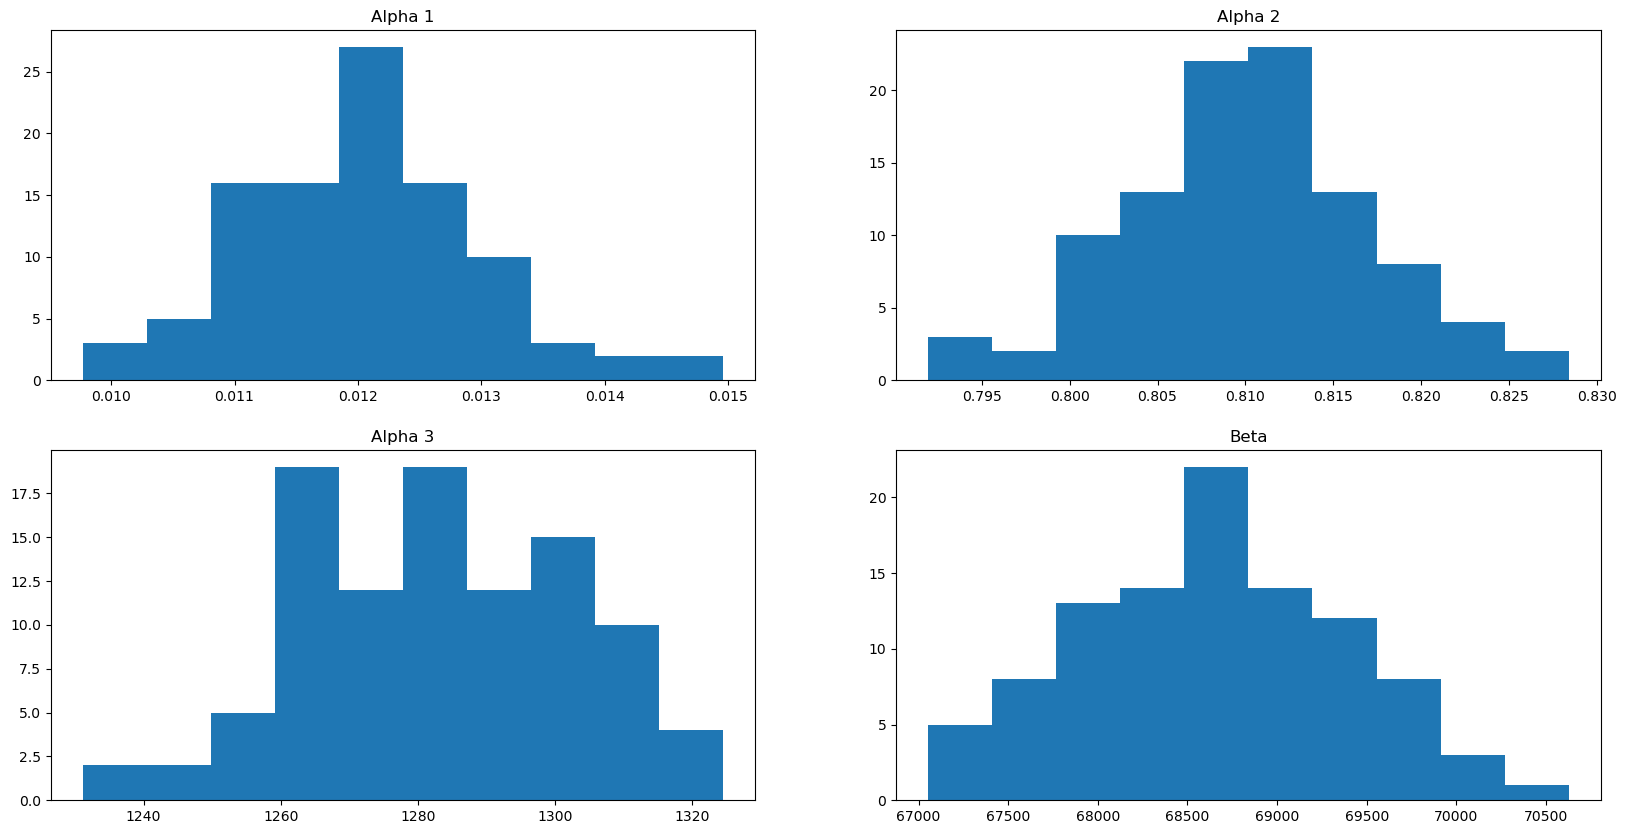

In [37]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.hist(post_2.alpha_1)
plt.title('Alpha 1')

plt.subplot(2,2,2)
plt.hist(post_2.alpha_2)
plt.title('Alpha 2')

plt.subplot(2,2,3)
plt.hist(post_2.alpha_3)
plt.title('Alpha 3')

plt.subplot(2,2,4)
plt.hist(post_2.beta)
plt.title('Beta')

plt.show()

### 7. Model comparison

- Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]

The WAIC and LOO (information criteria) were used for model comparison, and both indicated that the more complex model achieves better results, which is also consistent with the level of fit of the plotted graph over the entire data range. However, if we consider only the subset of data that was not included in the model fitting process, the less complex model performs better.

In [38]:
# Compare the models using LOO
loo_compare = az.compare({"income": post_1, "Income/household/mean_age": post_2}, ic="loo")

az.plot_compare(loo_compare)
plt.show()
loo_compare

NameError: name 'post_1' is not defined

In [ ]:
az.loo(post_1)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -219.67     3.03
p_loo        1.88        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       22   88.0%
 (0.5, 0.7]   (ok)          3   12.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [ ]:
az.loo(post_2)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -204.48     8.27
p_loo        5.24        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       20   80.0%
 (0.5, 0.7]   (ok)          5   20.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

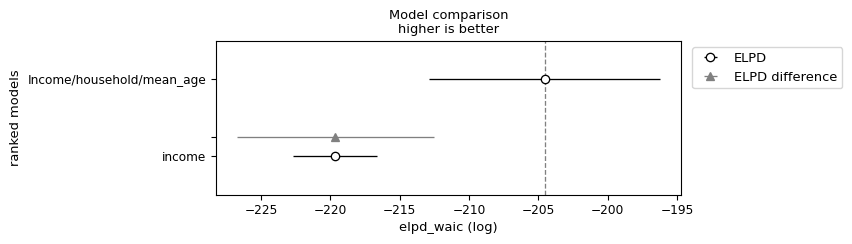

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Income/household/mean_age,0,-204.559909,5.317386,0.000000,0.853565,8.313655,0.000000,True,log
income,1,-219.649166,1.863305,15.089257,0.146435,3.027059,7.079213,False,log


In [ ]:
# Compare the models using WAIC
waic_compare = az.compare({"income": post_1, "Income/household/mean_age": post_2}, ic="waic")

az.plot_compare(waic_compare)
plt.show()
waic_compare

In [ ]:
az.waic(post_1)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -219.65     3.03
p_waic        1.86        -

In [ ]:
az.waic(post_2)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -204.56     8.31
p_waic        5.32        -

There has been a warning during the calculation. Please check the results.

For both criteria, the more complex model achieved a higher score, so it can be considered better than the simpler one.

In [ ]:
data = {'N': 5, 'income': df_all['Income per member'][25:], 'y': df_all['Married'][25:]}
post_test_1 = model_1_posterior.sample(data=data, chains=1, iter_sampling=R)

data = {'N': 5, 'income': df_all['Income per member'][25:], 'household': df_all['Household'][25:], 'mean_age': df_all['Mean age'][25:], 'y': df_all['Married'][25:]}
post_test_2 = model_2_posterior.sample(data=data, chains=1, iter_sampling=R)

13:59:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


13:59:12 - cmdstanpy - INFO - CmdStan done processing.
13:59:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |██████████| 00:00 Sampling completed                     


13:59:12 - cmdstanpy - INFO - CmdStan done processing.


In [ ]:
post_test_2.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-75.245200,0.192348,1.339390,-78.153800,-75.056400,-73.514900,48.4886,3232.57,1.037410
alpha_1,0.011949,0.000101,0.000868,0.010778,0.011909,0.013294,73.7950,4919.66,1.001110
alpha_2,0.808330,0.000610,0.008060,0.793901,0.808318,0.820451,174.5800,11638.70,0.992856
alpha_3,1283.290000,1.844890,17.176600,1252.520000,1282.800000,1310.720000,86.6828,5778.85,0.995714
beta,69403.900000,86.597100,1080.160000,67563.900000,69337.200000,71294.000000,155.5860,10372.40,0.993918
sigma,425.541000,3.695040,22.354200,387.713000,425.982000,462.634000,36.6001,2440.01,1.047360
y_sim[1],136072.000000,47.152800,480.994000,135351.000000,136062.000000,136769.000000,104.0550,6937.02,0.997465
y_sim[2],136681.000000,44.702500,461.750000,135897.000000,136749.000000,137330.000000,106.6960,7113.10,0.995322
y_sim[3],136096.000000,45.887000,493.067000,135284.000000,136091.000000,136814.000000,115.4600,7697.36,0.990067
y_sim[4],136587.000000,57.087500,465.459000,135863.000000,136588.000000,137289.000000,66.4783,4431.89,0.989959


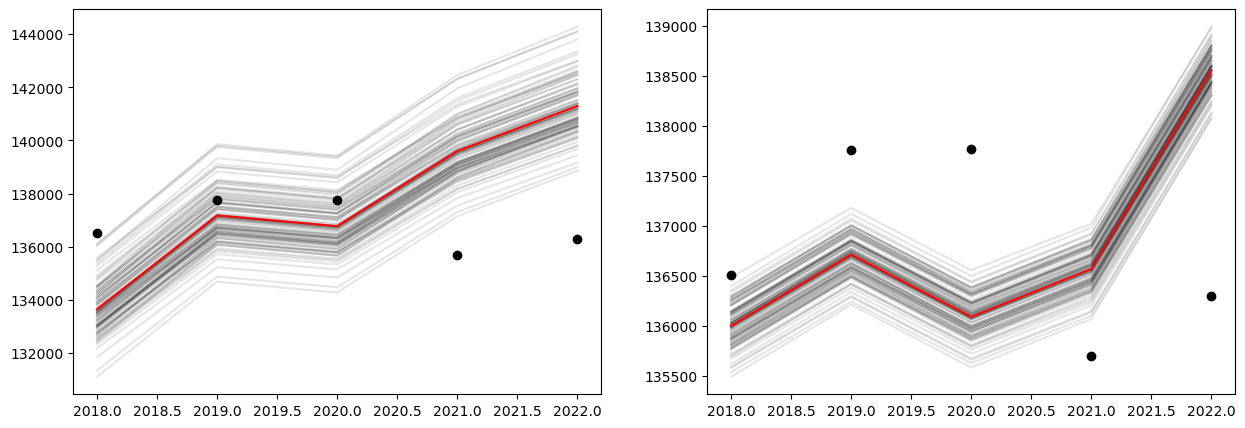

In [ ]:
plt.figure(figsize=(15,5))

df_whole = df_all
df_all = df_all[25:]
plt.subplot(1,2,1)
for i in range(len(post_test_1.y_sim)):
    plt.plot(df_all['Year'], post_test_1.alpha[i]*df_all['Income per member'] + post_test_1.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_1.alpha.mean()*df_all['Income per member'] + post_test_1.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.subplot(1,2,2)
for i in range(len(post_test_2.y_sim)):
    plt.plot(df_all['Year'], post_test_2.alpha_1[i]*df_all['Income per member'] + post_test_2.alpha_2[i]*df_all['Household'] - post_test_2.alpha_3[i]*df_all['Mean age'] + post_test_2.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_2.alpha_1.mean()*df_all['Income per member'] + post_test_2.alpha_2.mean()*df_all['Household'] - post_test_2.alpha_3.mean()*df_all['Mean age'] + post_test_2.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.show()

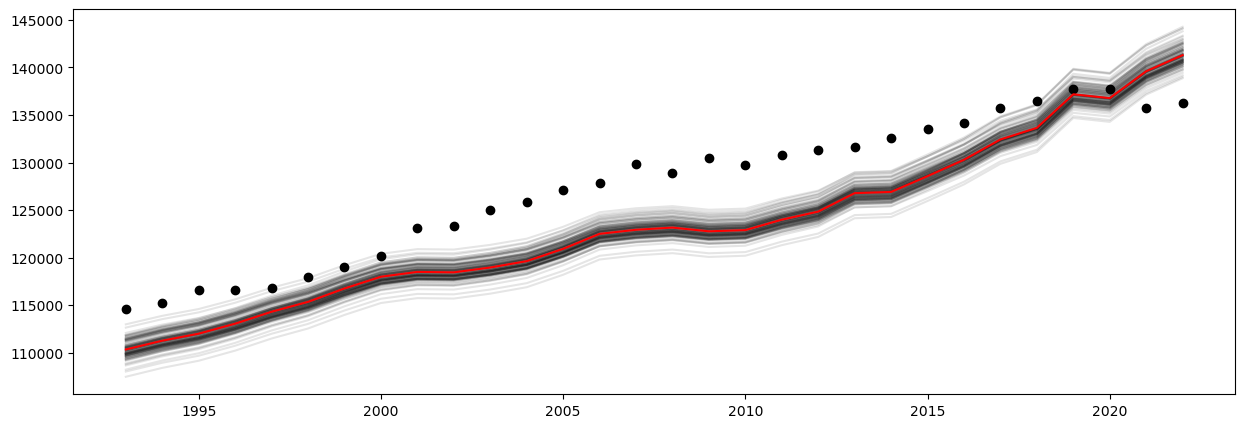

In [ ]:
plt.figure(figsize=(15,5))

df_all = df_whole
for i in range(len(post_test_1.y_sim)):
    plt.plot(df_all['Year'], post_test_1.alpha[i]*df_all['Income per member'] + post_test_1.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_1.alpha.mean()*df_all['Income per member'] + post_test_1.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.show()

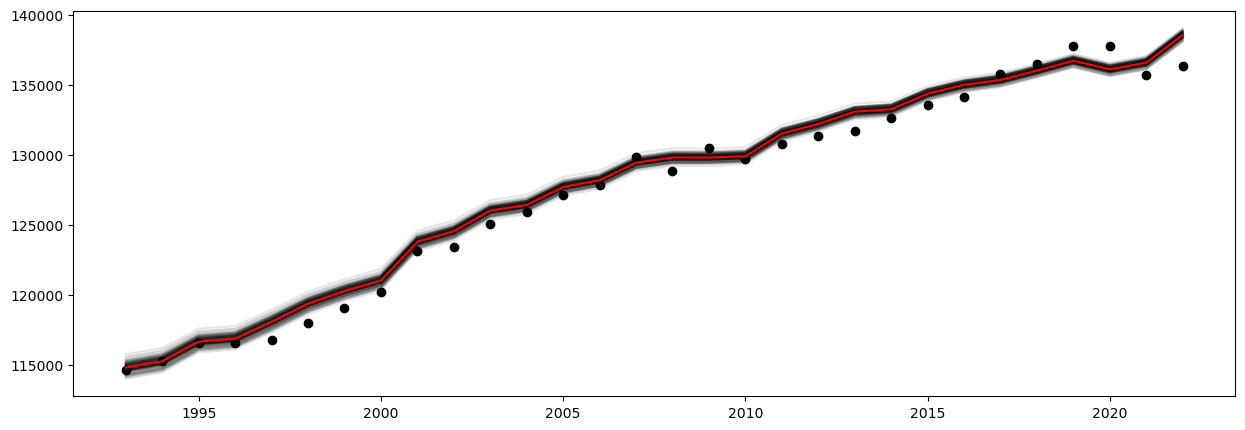

In [ ]:
plt.figure(figsize=(15,5))

df_all = df_whole
for i in range(len(post_test_2.y_sim)):
    plt.plot(df_all['Year'], post_test_2.alpha_1[i]*df_all['Income per member'] + post_test_2.alpha_2[i]*df_all['Household'] - post_test_2.alpha_3[i]*df_all['Mean age'] + post_test_2.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_2.alpha_1.mean()*df_all['Income per member'] + post_test_2.alpha_2.mean()*df_all['Household'] - post_test_2.alpha_3.mean()*df_all['Mean age'] + post_test_2.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.show()